# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




# Import Libraries

In [25]:
import warnings
import csv
import numpy as np
import pandas as pd


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199


from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, accuracy_score,confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut, KFold
from sklearn.feature_selection import RFE, SelectFromModel, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.decomposition import PCA
import sklearn.manifold
import umap.umap_ as umap

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# scaling
from sklearn.preprocessing import StandardScaler

# Load data

In [2]:
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

# Plotting data in 2D with axes sampled 
## a) At random 
## b) From same electrode
## c) From same feature type

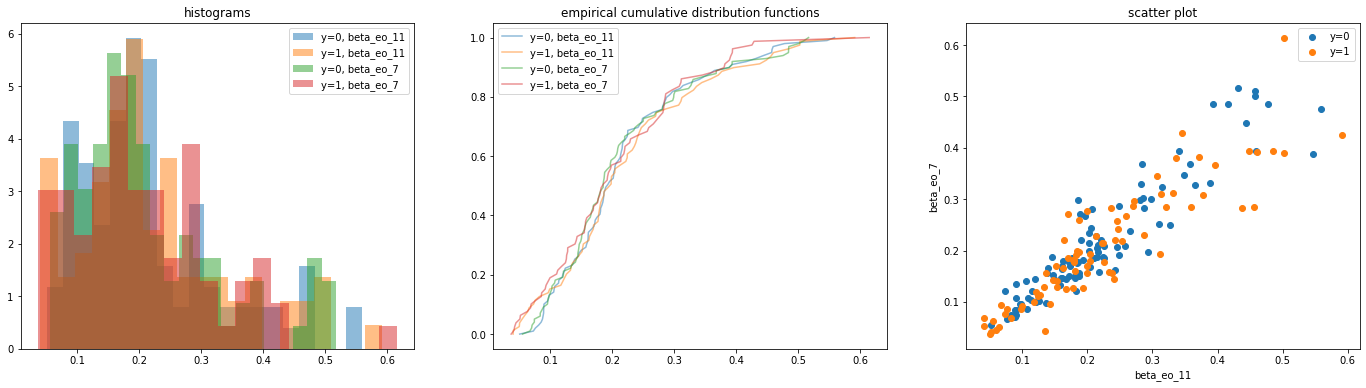

In [3]:
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

#b) same electrode, different feature (uncomment lines below)
f0, f1 = np.random.randint(0, num_features, size=2)
e = np.random.randint(0, num_electrodes)
i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

#c) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

# Defining Models and Cross Validation Scheme

In [4]:
models = [
          ('LogReg', LogisticRegression()), 
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC(kernel='linear')), 
        ]
scaler = StandardScaler()
clf = LogisticRegression()
kf = KFold(n_splits=18, shuffle=False)

# Evaluation Function

In [5]:
def evaluate(models, data, kf):
    results = []
    for name, model in models:
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        # train loop
        for train_index, test_index in kf.split(data):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            #Applying Scaling
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": name,
            "accuracy": np.mean(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [6]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

# Baseline Benchmark.

In [7]:
results = evaluate(models, X, kf)
results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.933333,0.9250,0.94,0.93250
1,KNN,0.855556,0.7875,0.91,0.84875
2,SVM,0.900000,0.9000,0.90,0.90000


# Removing highly correlated features

In [8]:
X_corr = corr_df(pd.DataFrame(X), 0.9)
X_corr = X_corr.to_numpy()
X_corr.shape

(180, 256)

# Performance after removing correlated features

In [9]:
results = evaluate(models, X_corr, kf)
results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.883333,0.8625,0.90,0.88125
1,KNN,0.872222,0.7875,0.94,0.86375
2,SVM,0.877778,0.8625,0.89,0.87625


# Using RFECV to find optimal value of K on Scaled dataset

Optimal number of features : 262


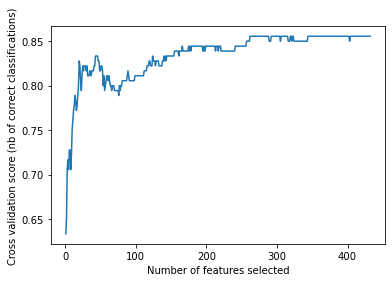

In [10]:
rfecv = RFECV(estimator=clf, step=1, cv=kf.split(X), scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [11]:
features = rfecv.get_support(indices=True)
rfecv_data = X[:,features]  
rfecv_results = evaluate(models, rfecv_data, kf)
rfecv_results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.933333,0.9125,0.95,0.93125
1,KNN,0.866667,0.7875,0.93,0.85875
2,SVM,0.922222,0.9000,0.94,0.92000


# RFECV on Correlation dataset.

Optimal number of features : 37


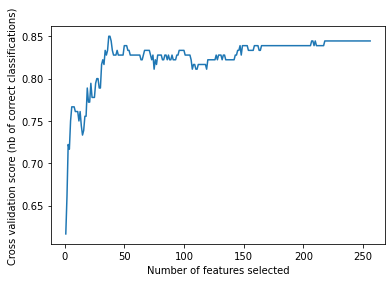

In [12]:
rfecv = RFECV(estimator=clf, step=1, cv=kf.split(X_corr), scoring='accuracy')
rfecv.fit(X_corr, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [13]:
features = rfecv.get_support(indices=True)
rfecv_corr_data = X_corr[:,features]  
rfecv_corr_results = evaluate(models, rfecv_corr_data, kf)
rfecv_corr_results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.905556,0.875,0.93,0.9025
1,KNN,0.833333,0.800,0.86,0.8300
2,SVM,0.883333,0.850,0.91,0.8800


# ANOVA filter method on scaled dataset.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model = Pipeline([('skb', SelectKBest(f_classif, k = 10)),
                    ('svm', SVC(kernel='linear'))])
clf_1 = GridSearchCV(model, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy')
clf_1.fit(X, y) 

GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001BA403BD350>,
             estimator=Pipeline(steps=[('skb', SelectKBest()),
                                       ('svm', SVC(kernel='linear'))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                    14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                    25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [15]:
clf_1.best_params_.values()
best_k_value = [x for x in clf_1.best_params_.values()][0]
print(best_k_value)

151


In [16]:
anova = SelectKBest(f_classif, k=best_k_value) 
anova_data = anova.fit_transform(X, y)
features = anova.get_support(indices=True)
anova_data = X[:,features]  
anova_results = evaluate(models, anova_data, kf)
anova_results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.894444,0.8625,0.92,0.89125
1,KNN,0.883333,0.8375,0.92,0.87875
2,SVM,0.877778,0.8500,0.90,0.87500


# Mutual Information filter method on original dataset.

In [17]:
classifier_1 = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)),
                       ('svm', SVC(kernel='linear'))])

clf_1 = GridSearchCV(classifier_1, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='accuracy')
clf_1.fit(X, y)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001BA403BD970>,
             estimator=Pipeline(steps=[('skb',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x000001BA333F2940>)),
                                       ('svm', SVC(kernel='linear'))]),
             param_grid={'skb__k': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101,
                                    111, 121, 131, 141, 151, 161, 171, 181, 191,
                                    201, 211, 221, 231, 241, 251, 261, 271, 281,
                                    291, ...]},
             scoring='accuracy')

In [18]:
clf_1.best_params_.values()
best_k_value = [x for x in clf_1.best_params_.values()][0]
print(best_k_value)

181


In [19]:
mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
mutual_info_data = mutual_info.fit_transform(X, y)
features = mutual_info.get_support(indices=True)
mutual_info_data = X[:,features] 
mutual_info_results = evaluate(models, mutual_info_data, kf)
mutual_info_results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.922222,0.9125,0.93,0.92125
1,KNN,0.883333,0.8500,0.91,0.88000
2,SVM,0.966667,0.9750,0.96,0.96750


# Lasso embedded method feature selection on scaled dataset.

In [20]:
lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
importance = importance[importance > 0]
features = np.where(importance != 0)[0]
lasso_data = X[:,features]
lasso_results = evaluate(models, lasso_data, kf)
lasso_results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.855556,0.8250,0.88,0.85250
1,KNN,0.816667,0.8000,0.83,0.81500
2,SVM,0.883333,0.8875,0.88,0.88375


# Random Forest based feature selection on scaled data.

In [21]:
rf_clf = RandomForestClassifier(n_estimators=2000, random_state=0, n_jobs=-1)
# Create a selector object that will use the random forest classifier to identify
sfm = SelectFromModel(rf_clf)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=2000, n_jobs=-1,
                                                 random_state=0))

# Number of features after filtering

In [22]:
print(len(sfm.get_support(indices=True)))

138


In [23]:
rf_importance_data = sfm.transform(X)
rf_importance_results = evaluate(models, rf_importance_data, kf)
rf_importance_results

,model,accuracy,sensitivity,specificity,auc
0,LogReg,0.911111,0.9000,0.92,0.91000
1,KNN,0.894444,0.8375,0.94,0.88875
2,SVM,0.900000,0.9000,0.90,0.90000


# Projection Methods for Feature Extraction.

# PCA

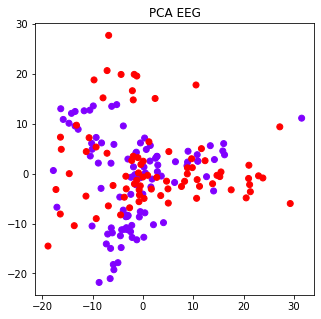

In [26]:
plt.figure(figsize=(5,5))
plt.title("PCA EEG")

# apply principal component analysis
pca = PCA(n_components=2)
pipe = make_pipeline(StandardScaler(),
                pca)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')

In [27]:
pipe = make_pipeline(StandardScaler(),
                PCA(n_components=1),
                LogisticRegression())

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'pca__n_components': (1,2,3,4,5,10,20,30,None)
    },
    scoring='accuracy',
    cv=kf.split(X)
)

grid_result = gsc.fit(X,y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.933333 using {'pca__n_components': None}


# TSNE

Text(0.5, 1.0, 'EEG tSNE')

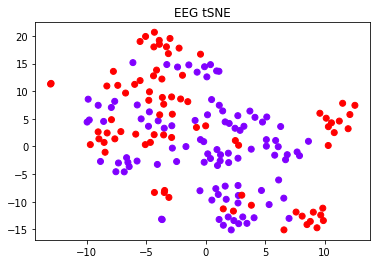

In [28]:
tsne  = sklearn.manifold.TSNE()
pipe = make_pipeline(StandardScaler(),
                tsne)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("EEG tSNE")

# UMAP

Text(0.5, 1.0, 'UMAP tSNE')

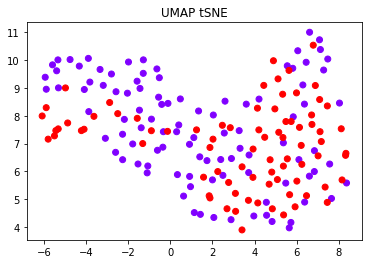

In [29]:
umap  = umap.UMAP(min_dist=0.9,n_components=2)
pipe = make_pipeline(StandardScaler(),
                umap)
X_2d = umap.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("UMAP tSNE")

In [ ]:
# results = []
# for k in range(1,432):
#     model = Pipeline([('skb', SelectKBest(f_classif, k = k)),
#                        ('svm', SVC(kernel='linear'))])
#     y_pred, y_true = [], []
#     # train loop
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         model.fit(X_train, y_train)
#         y_model_predict = model.predict(X_test)
#         y_pred.extend(y_model_predict)
#         y_true.extend(y_test)
#     # calculate metrics
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     auc = roc_auc_score(y_true, y_pred)
#     results.append(auc)